# Remi Project: TCR Proofreading by LAT

## Overview

The T cell receptor (TCR) is an ideal biological example of kinetic proofreading. While TCRs have higher affinity for foreign antigens than self, this affinity difference does not account for the ability of TCRs to discriminate between the two with the high fidelity that they are observed to have. Therefore, it has been proposed that the TCR uses kinetic proofreading to improve specificity of antigen recognition without increasing affinity for the target. This happens by slowing the off rate for the "right" substrate above that for the "wrong," allowing the system more time to complete signaling complex assembly only for the correct ligand. One of these steps in the TCR has been shown to be the duration of time it takes for Zap70 to scan for LCK-bound coreceptors (CD4 or CD8). However, the mechanisms by which further proofreading happens have remained unclear until recently. 

A new paper in Nature Immunology (Weiss, 2023) has shown that the TCR likely proofreads its target in another step, by Zap70 phosphorylation of the Y132 residue on linker for activation of T cells (LAT). This residue is analogous to Y136 in mice. This provides another proofreading step because this tyrosine is a poor Zap70 substrate, requiring time to react and induce downstream signaling. However, mutations at this locus that make it a better Zap70 substrate reduce the ability of TCRs to proofread substrates. 

In this notebook, I will use a model of a transgenic TCR with known peptide affinity

created conda environment:

conda create --name CSB4 -c conda-forge python jupyterlab matplotlib pandas numpy scipy biopython nglview ipywidgets=7!"


In [245]:
%reset
# this command will reset all of the variables in your notebook.

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [246]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## 1. Structure of LAT

First, let's use AlphaFold to visualize the structure of LAT. It is a membrane protein, making it very difficult to obtain crystal structures for. As such, its structure remains unsolved by X-ray crystallography or cryoEM. Data downloaded from AlphaFold for UniProt ID 054957, "Linker for activation of T-cells family member 1."

In [187]:
# Import cell (RUN THIS CELL TO TEST YOUR INSTALL/ENVIRONMENT)
# part 1
from Bio.PDB import *
import nglview as nv
import ipywidgets
# part 2
from Bio import SeqIO
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

In [189]:
pdb_parser = PDBParser()
structure = pdb_parser.get_structure("P", "lat.pdb")
view = nv.show_biopython(structure)
view
 


# note low confidence (colors dont mean confidence here)
# note alpha helix, we know
# rest unknown


NGLWidget()

## 2. Model TCR Error Rates

TCRs have very low error rates, much lower than the thermodynamics of the difference in binding affinities for correct ("c") ligands or self ("s") ligands would predict. Given that the difference in their affinities is 10-fold, this means that the dissociation time of the correct substrate is 10x as long as the self ligand (since their on rates are the same). 

To demonstrate error rate, let's use the equation from the Hopfield paper for error rate ($f = \frac{(k_{C}+W)}{(k_{D}+W)}$) to predict the error rate we could assume using 10x difference in off rates of each substrate. We will use an arbitrary product off-rate (W) of 1. 

In [203]:
#define off rate
W = 1

#define off rates (c = correct, s = self ligand)
kc_off = 1
kd_off = 10
f = (kc_off + W)/(kd_off + W) #error rate calculation


print('Error rate (f) is:', np.round(f,4))

Error rate (f) is: 0.1818


We can see that that the error rate using these parameters based on affinity is roughly 0.18, which is just about proportionate to their differences in dissociation constants.

## 3. Implement Kinetic Proofreading for TCRs

We have previously seen that kinetic proofreading can be implemented as a method to decrease error rates from $f$ to $f^{n}$ by implementing $n$ number of proofreading steps. Unlike the model we previously explored, TCRs likely use two proofreading steps (Weiss, 2021), unlike the single step presented in class.

We will implement this model with two proofreading steps to see how this changes error rates.

# KEY ASSUMPTIONS:

1. these proofreading reactions are energy driven, causing the formation of high energy phoshorylated intermediates. Therefore, on rates to the modified enzyme-substrate complexes will be negligible (lc_on = hc_on = 0, same for ld or hd).
2. since these two proofreading reactions are energy driven, their reverse reactions are also negligible. Therefore, mc_r = md_r = 0.
3. on rates don't discriminate in this model, off rates do. Therefore, kc_on = kd_on; mc_on = md_on, etc.
4. the intermediate steps are nonspecific, so their rates are just m or n (no difference for correct or incorrect substrate)

In [247]:
def KP_dynamics_2(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,nc,nc_r,nd,nd_r,hc_on,hc_off,hd_on,hd_off,w,w_r,c_total):
    #y[0] = [C] correct substrate
    #y[1] = [D] incorrect substrate
    #y[2] = [Cc] correct enzyme substrate complex
    #y[3] = [Dc] incorrect enzyme substrate complex
    #y[4] = [Cc*] correct enzyme substrate complex *modified
    #y[5] = [Dc*] incorrect enzyme substrate complex *modified
    #y[6] = [Cc**] correct enzyme substrate complex **double modified
    #y[7] = [Dc**] incorrect enzyme substrate complex **double modified
    #y[8] = [PC] correct product
    #y[9] = [PD] incorrect product
    
    
    #dydt[0] = rate of change of [C]
    #dydt[1] = rate of change of [D]
    #dydt[2] = rate of change of [Cc]
    #dydt[3] = rate of change of [Dc]
    #dydt[4] = rate of change of [Cc*]
    #dydt[5] = rate of change of [Dc*]
    #dydt[6] = rate of change of [Cc**]
    #dydt[7] = rate of change of [Dc**]
    #dydt[8] = rate of change of [PC]
    #dydt[9] = rate of change of [CD]
    
    
    # c = c_total - (Cc + Dc + Cc* + Dc* + Cc** + Dc**) ?
    
    dydt = np.zeros(10)
    
    # dynamics on concentrations of substrates (built 4/27 9:30am)
    dydt[0] = y[2]*kc_off + y[4]*lc_off + y[6]*hc_off - y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*(kc_on+lc_on+hc_on)
    dydt[1] = y[3]*kd_off + y[5]*ld_off + y[7]*hd_off- y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*(kd_on+ld_on+hd_on)
    
     # dynamics on concentrations of enzyme-substrate complexes
    dydt[2] = y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*kc_on + y[4]*mc_r - y[2]*(kc_off+mc)
    dydt[3] = y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*kd_on + y[5]*md_r - y[3]*(kd_off+md)
    dydt[4] = y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*lc_on + y[2]*mc + y[6]*nc_r - y[4]*(mc_r+lc_off+nc)
    dydt[5] = y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*ld_on + y[3]*md + y[7]*nd_r - y[5]*(md_r+ld_off+nd)
    dydt[6] = y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*hc_on + y[4]*nc + y[8]*w_r - y[6]*(nc_r+hc_off+w)
    dydt[7] = y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]+y[6]+y[7]))*hd_on + y[5]*nd + y[9]*w_r - y[7]*(nd_r+hd_off+w)
    dydt[8] = y[6]*w - y[8]*w_r
    dydt[9] = y[7]*w - y[9]*w_r
    

    return dydt

In [255]:
# Parameters
kc_on = 1
kc_off = 1
kd_on = kc_on #equal on-rate assumption
kd_off = 10
lc_on = 0 #high energy intermediate
lc_off = kc_off #for simplicity
ld_on = 0 #high energy intermediate
ld_off = kd_off #for simplicity
mc = 1
mc_r = 0 #energy driven step = irreversible
md = mc # Hopfield assumption
md_r = 0
hc_on = 0 #high energy intermediate
hc_off = kc_off #for simplicity
hd_on = 0 #high energy intermediate
hd_off = kd_off #for simplicity
nc = 1
nc_r = 0
nd = nc # Hopfield assumption
nd_r = 0



w = 1
w_r = 1
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0,0,0]

# time span
t = np.linspace(0,3,1000)
tspan = [t[0],t[-1]]

In [256]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_2(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,nc,nc_r,nd,nd_r,hc_on,hc_off,hd_on,hd_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
final error rate:0.00546


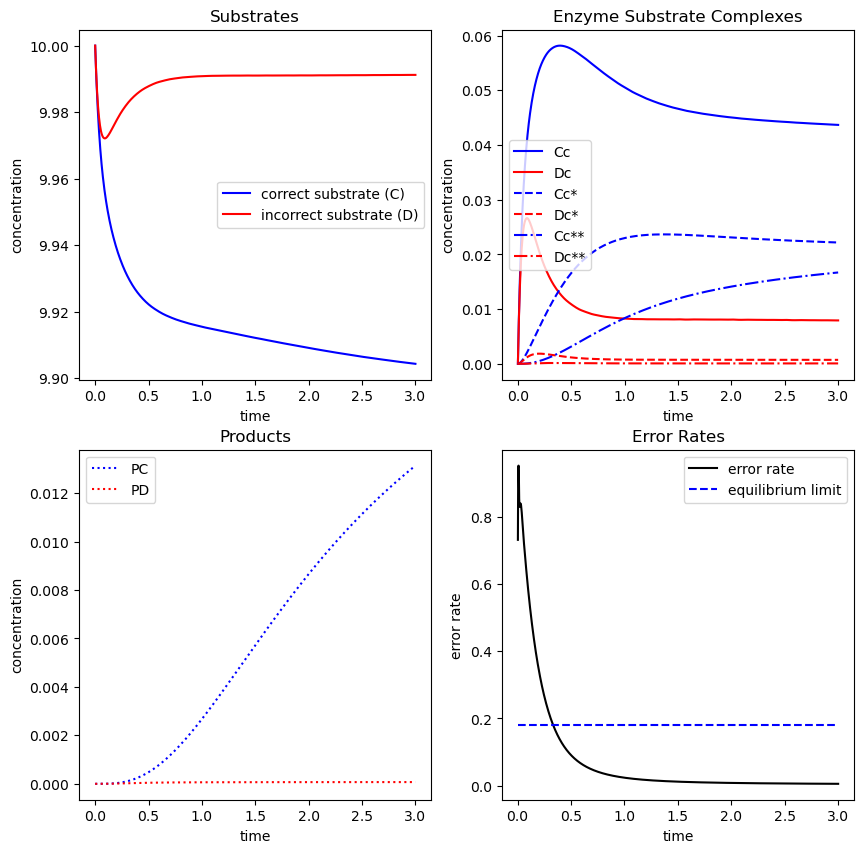

In [258]:
# Plot
fig,axs = plt.subplots(2,2,figsize=(10, 10))

axs[0,0].set_title('Substrates')
axs[0,0].plot(t,ode_sol.y[0],'b-')
axs[0,0].plot(t,ode_sol.y[1],'r-')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('concentration')
axs[0,0].legend(['correct substrate (C)','incorrect substrate (D)']);

axs[0,1].set_title('Enzyme Substrate Complexes')
axs[0,1].plot(t,ode_sol.y[2],'b-')
axs[0,1].plot(t,ode_sol.y[3],'r-')
axs[0,1].plot(t,ode_sol.y[4],'b--')
axs[0,1].plot(t,ode_sol.y[5],'r--')
axs[0,1].plot(t,ode_sol.y[6],'b-.')
axs[0,1].plot(t,ode_sol.y[7],'r-.')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('concentration')
axs[0,1].legend(['Cc','Dc','Cc*','Dc*','Cc**','Dc**']);

axs[1,0].set_title('Products')
axs[1,0].plot(t,ode_sol.y[8],'b:')
axs[1,0].plot(t,ode_sol.y[9],'r:')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('concentration')
axs[1,0].legend(['PC','PD']);

axs[1,1].set_title('Error Rates')
st = 1
axs[1,1].plot(t[st:],ode_sol.y[9][st:]/ode_sol.y[8][st:],'k-')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W) #equation 3 from Hopfield

axs[1,1].plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs[1,1].legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[9][-1]/ode_sol.y[8][-1],5)))


## 4. Compare to only one step:
now, we will run the same differential equation model using the same constants, but with a kinetic mechanism with only one step, as was done in class.

In [259]:
def KP_dynamics_1(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,w,w_r,c_total):
    #y[0] = [C] correct substrate
    #y[1] = [D] incorrect substrate
    #y[2] = [Cc] correct enzyme substrate complex
    #y[3] = [Dc] incorrect enzyme substrate complex
    #y[4] = [Cc*] correct enzyme substrate complex *modified
    #y[5] = [Dc*] incorrect enzyme substrate complex *modified
    #y[6] = [PC] correct product
    #y[7] = [PD] incorrect product
    
    # c = c_total - (Cc + Dc + Cc* + Dc*)
    
    dydt = np.zeros(8)
    
    # dynamics on concentrations of substrates
    dydt[0] = y[2]*kc_off + y[4]*lc_off - y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]))*(kc_on+lc_on)
    dydt[1] = y[3]*kd_off + y[5]*ld_off - y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]))*(kd_on+ld_on)
    
    # constant concentrations of substrates
    #dydt[0] = 0
    #dydt[1] = 0 
    
    dydt[2] = y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]))*kc_on + y[4]*mc_r - y[2]*(kc_off+mc)
    dydt[3] = y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]))*kd_on + y[5]*md_r - y[3]*(kd_off+md)
    dydt[4] = y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]))*lc_on + y[2]*mc + y[6]*w_r - y[4]*(mc_r+lc_off+w)
    dydt[5] = y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]))*ld_on + y[3]*md + y[7]*w_r - y[5]*(md_r+ld_off+w)
    dydt[6] = y[4]*w - y[6]*w_r
    dydt[7] = y[5]*w - y[7]*w_r
    
    return dydt

In [260]:
# Parameters
kc_on = 1
kc_off = 1
kd_on = kc_on #equal on-rate assumption
kd_off = 10
lc_on = 0 #high energy intermediate
lc_off = kc_off #for simplicity
ld_on = 0 #high energy intermediate
ld_off = kd_off #for simplicity
mc = 1
mc_r = 0
md_r = 0

w = 1
w_r = 1
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0]

# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]

In [261]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_1(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
final error rate:0.0186


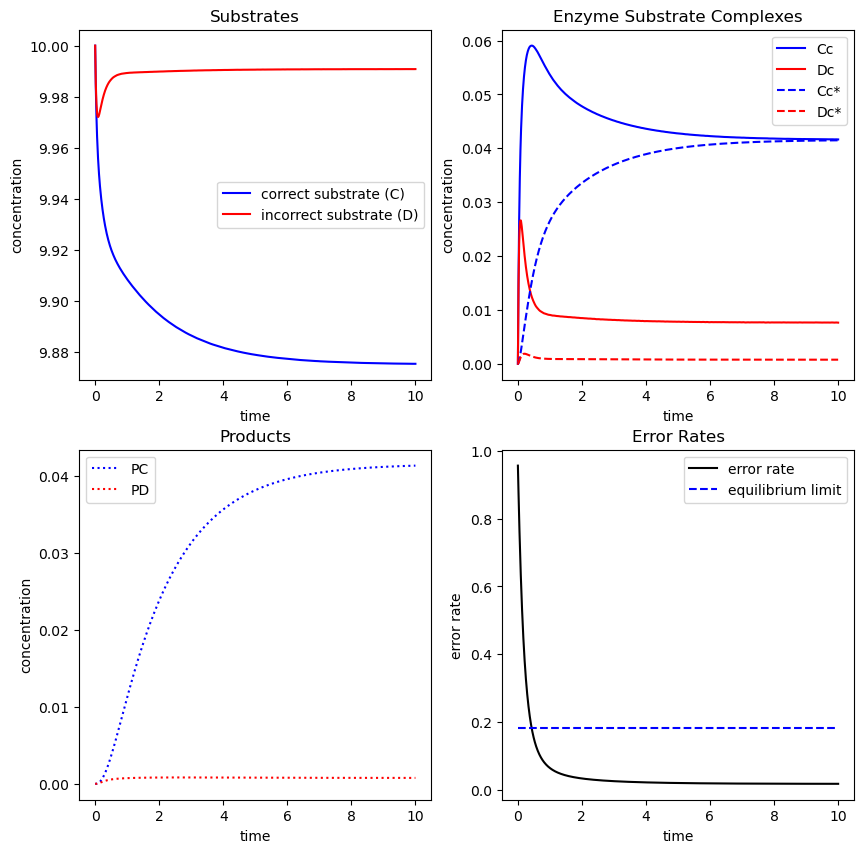

In [263]:
# Plot
fig,axs = plt.subplots(2,2,figsize=(10, 10))

axs[0,0].set_title('Substrates')
axs[0,0].plot(t,ode_sol.y[0],'b-')
axs[0,0].plot(t,ode_sol.y[1],'r-')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('concentration')
axs[0,0].legend(['correct substrate (C)','incorrect substrate (D)']);

axs[0,1].set_title('Enzyme Substrate Complexes')
axs[0,1].plot(t,ode_sol.y[2],'b-')
axs[0,1].plot(t,ode_sol.y[3],'r-')
axs[0,1].plot(t,ode_sol.y[4],'b--')
axs[0,1].plot(t,ode_sol.y[5],'r--')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('concentration')
axs[0,1].legend(['Cc','Dc','Cc*','Dc*']);

axs[1,0].set_title('Products')
axs[1,0].plot(t,ode_sol.y[6],'b:')
axs[1,0].plot(t,ode_sol.y[7],'r:')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('concentration')
axs[1,0].legend(['PC','PD']);

axs[1,1].set_title('Error Rates')
st = 1
axs[1,1].plot(t[st:],ode_sol.y[7][st:]/ode_sol.y[6][st:],'k-')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs[1,1].plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs[1,1].legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[7][-1]/ode_sol.y[6][-1],4)))


## 5. Compare different Product Formation Rates (W)

Now, lets compare both equations again but with different product formation rates. I will take some fast ones (high W, increases error rate) and compare to slower rates of product formation (lower error rate).

In [ ]:
# FIRST, let's do the single proofreading step model:

In [209]:
# Parameters for 1 step & low W
kc_on = 1
kc_off = 1
kd_on = kc_on #equal on-rate assumption
kd_off = 10
lc_on = 0 #high energy intermediate
lc_off = kc_off #for simplicity
ld_on = 0 #high energy intermediate
ld_off = kd_off #for simplicity
mc = 1
mc_r = 0
md_r = 0

w = 1
w_r = 1
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0]

# time span
t = np.linspace(0,3,1000)
tspan = [t[0],t[-1]]

In [210]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_1(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
Kinetic Proofreading error rate:0.0331
final error rate:0.0264


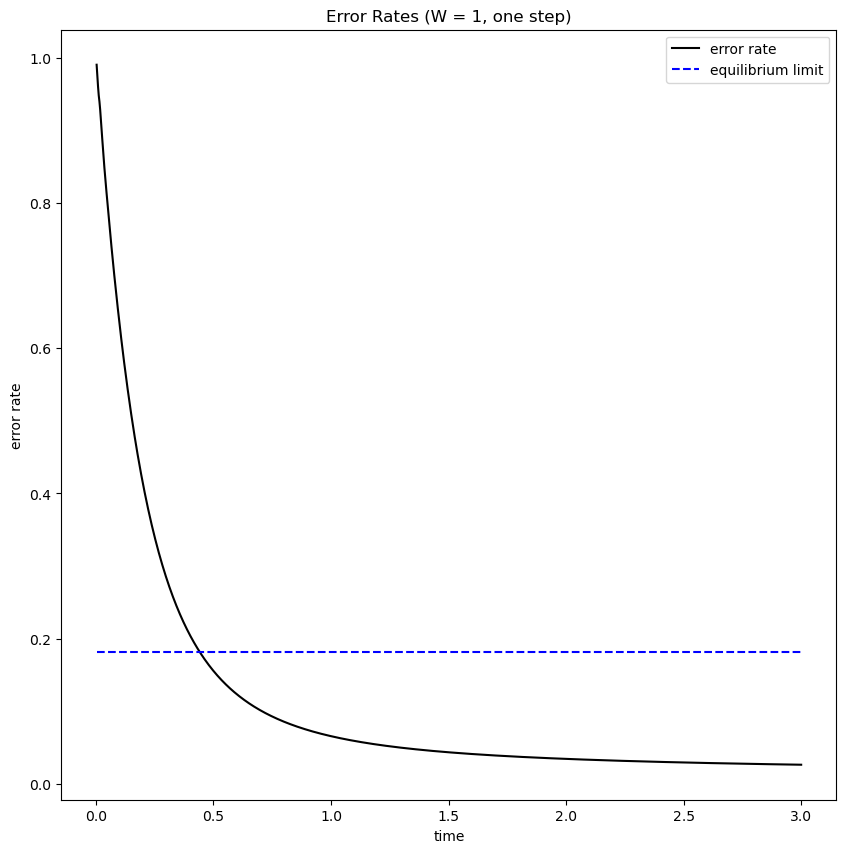

In [211]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (W = 1, one step)')
st = 1
axs.plot(t[st:],ode_sol.y[7][st:]/ode_sol.y[6][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('Kinetic Proofreading error rate:'+str(np.round(KP_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[7][-1]/ode_sol.y[6][-1],4)))

plt.savefig('1step_w1.jpg')  


In [212]:
# Parameter change for 1 step & medium W
w = 10

In [213]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_1(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
Kinetic Proofreading error rate:0.0331
final error rate:0.0686


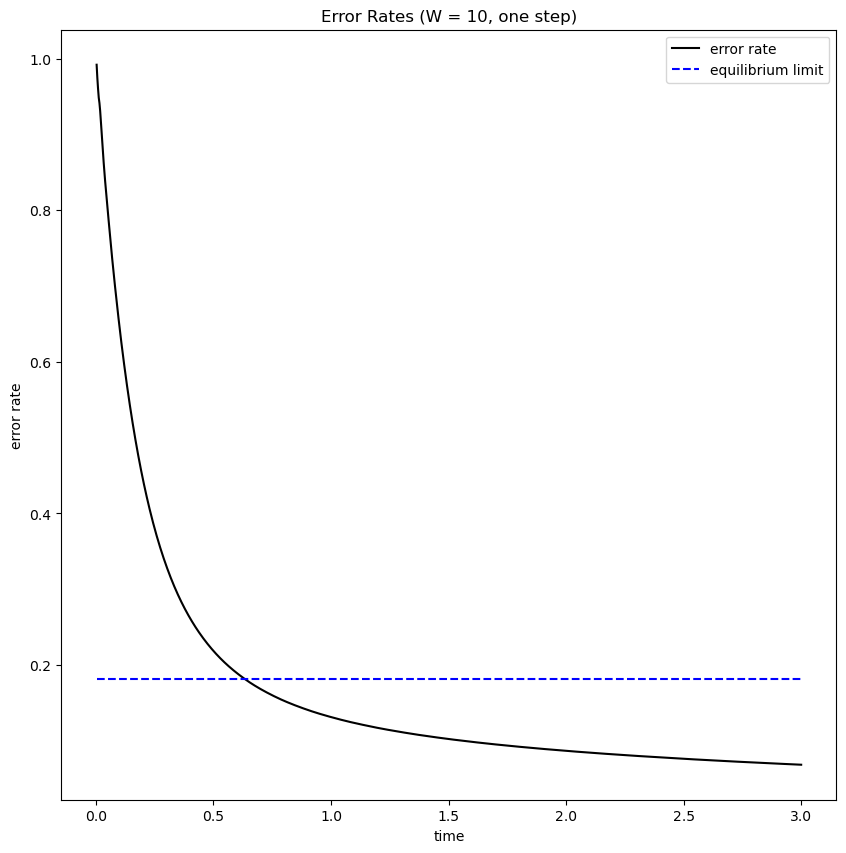

In [214]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (W = 10, one step)')
st = 1
axs.plot(t[st:],ode_sol.y[7][st:]/ode_sol.y[6][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('Kinetic Proofreading error rate:'+str(np.round(KP_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[7][-1]/ode_sol.y[6][-1],4)))

plt.savefig('1step_w10.jpg')  

In [215]:
# Parameters for 1 step & high W
w = 100

In [216]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_1(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
Kinetic Proofreading error rate:0.0331
final error rate:0.1699


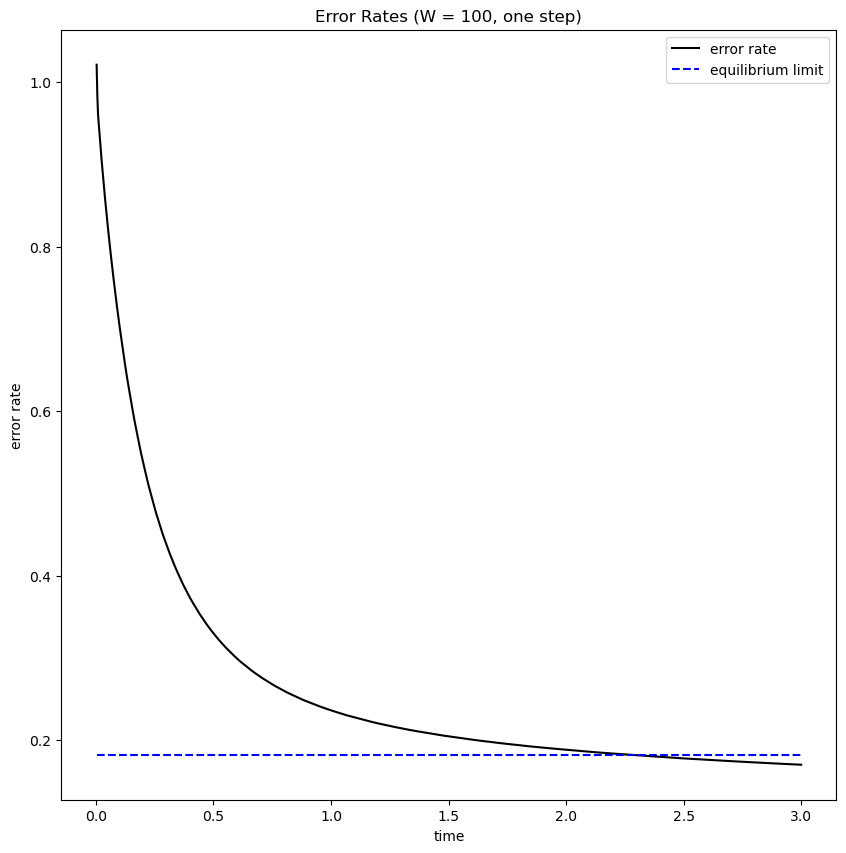

In [217]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (W = 100, one step)')
st = 1
axs.plot(t[st:],ode_sol.y[7][st:]/ode_sol.y[6][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('Kinetic Proofreading error rate:'+str(np.round(KP_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[7][-1]/ode_sol.y[6][-1],4)))

plt.savefig('1step_w100.jpg')  


In [218]:
# Now, repeat with 2 proofreading steps and low W

In [219]:
# Parameters
kc_on = 1
kc_off = 1
kd_on = kc_on #equal on-rate assumption
kd_off = 10
lc_on = 0 #high energy intermediate
lc_off = kc_off #for simplicity
ld_on = 0 #high energy intermediate
ld_off = kd_off #for simplicity
mc = 1
mc_r = 0 #energy driven step = irreversible
md = mc # Hopfield assumption
md_r = 0
hc_on = 0 #high energy intermediate
hc_off = kc_off #for simplicity
hd_on = 0 #high energy intermediate
hd_off = kd_off #for simplicity
nc = 1
nc_r = 0
nd = nc # Hopfield assumption
nd_r = 0



w = 1
w_r = 1
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0,0,0]

# time span
t = np.linspace(0,3,1000)
tspan = [t[0],t[-1]]

In [220]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_2(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,nc,nc_r,nd,nd_r,hc_on,hc_off,hd_on,hd_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
Kinetic Proofreading error rate:0.0331
final error rate:0.0055


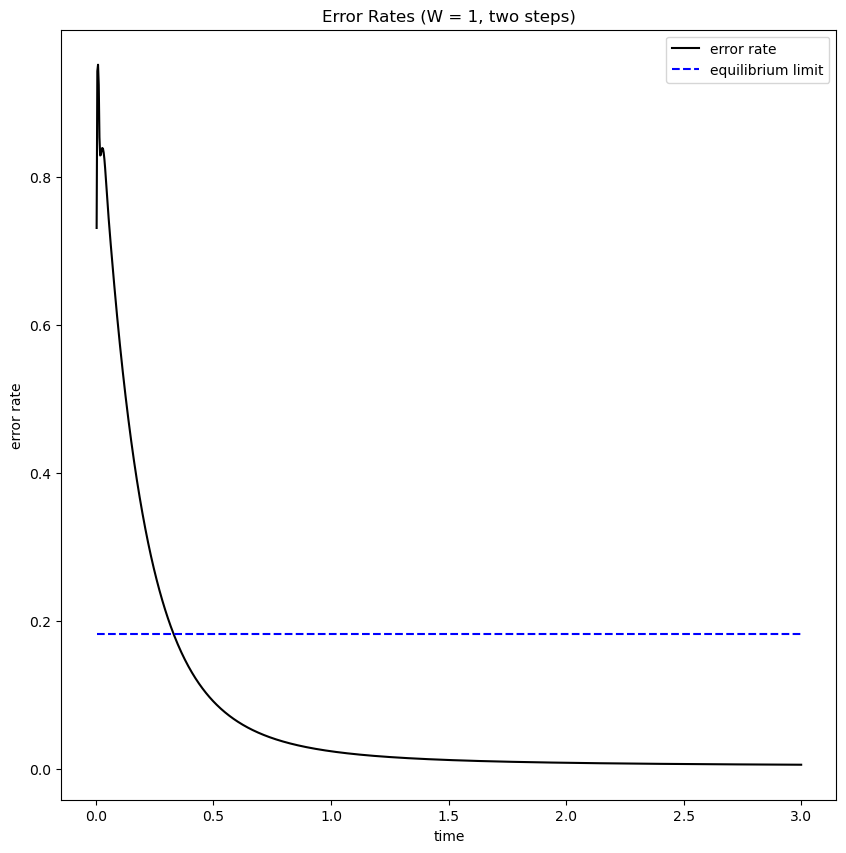

In [221]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (W = 1, two steps)')
st = 1
axs.plot(t[st:],ode_sol.y[9][st:]/ode_sol.y[8][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('Kinetic Proofreading error rate:'+str(np.round(KP_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[9][-1]/ode_sol.y[8][-1],4)))

plt.savefig('2step_w1.jpg')  


In [222]:
# Parameter change for 2 step & medium W
w = 10

In [223]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_2(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,nc,nc_r,nd,nd_r,hc_on,hc_off,hd_on,hd_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
Kinetic Proofreading error rate:0.0331
final error rate:0.0143


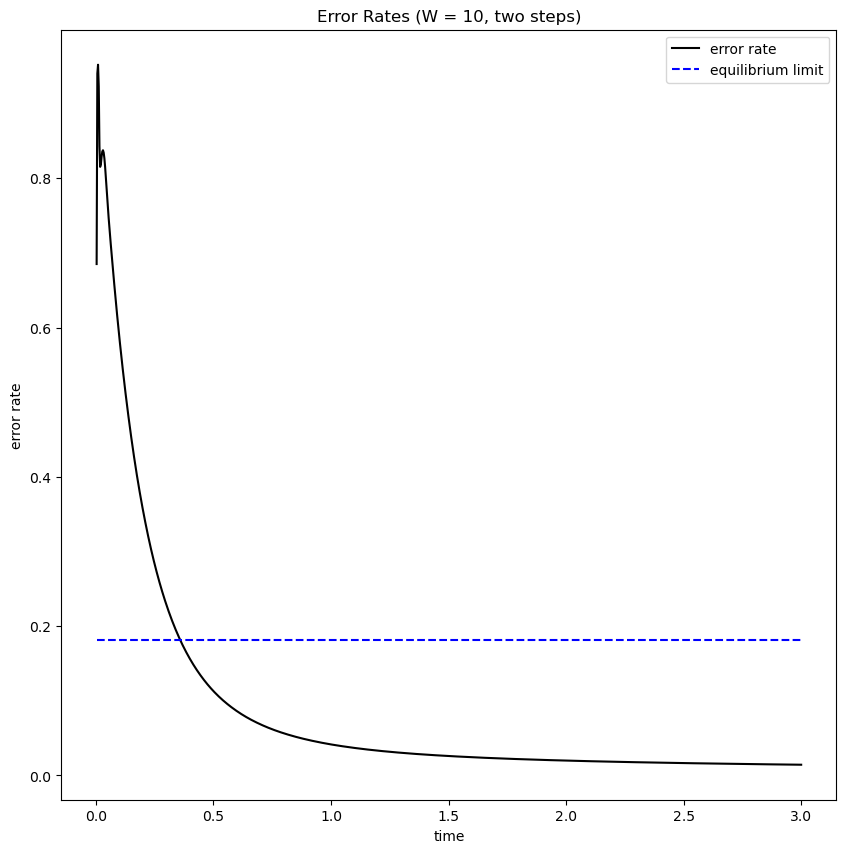

In [224]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (W = 10, two steps)')
st = 1
axs.plot(t[st:],ode_sol.y[9][st:]/ode_sol.y[8][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('Kinetic Proofreading error rate:'+str(np.round(KP_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[9][-1]/ode_sol.y[8][-1],4)))

plt.savefig('2step_w10.jpg')  


In [225]:
# Parameter change for 2 step & high W
w = 100

In [226]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_2(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,nc,nc_r,nd,nd_r,hc_on,hc_off,hd_on,hd_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
Kinetic Proofreading error rate:0.0331
final error rate:0.0356


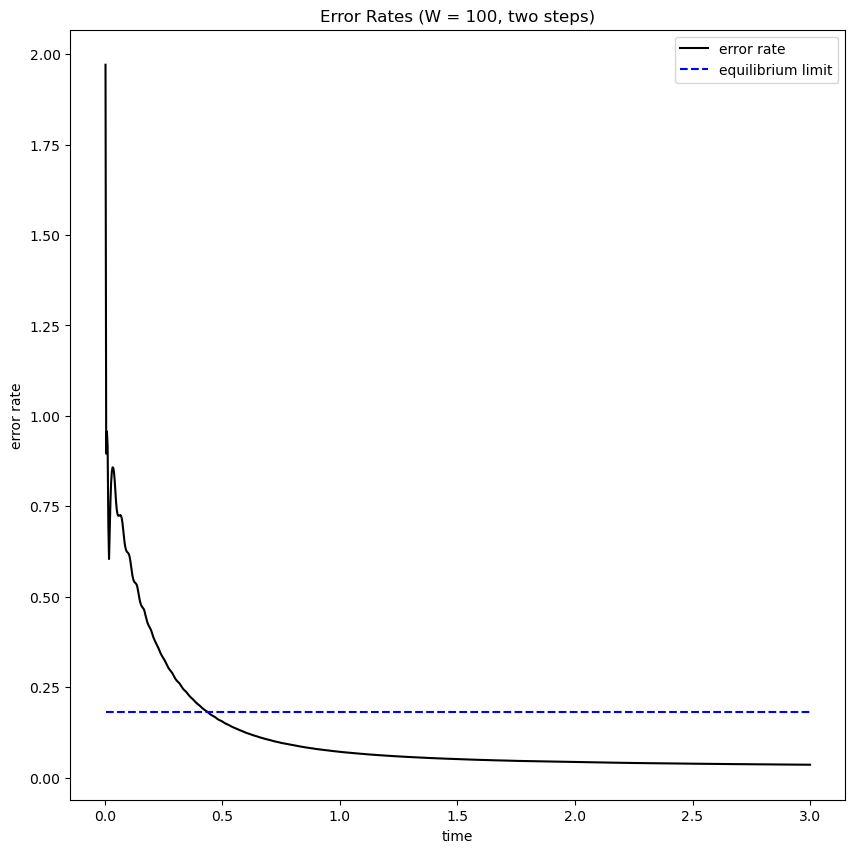

In [227]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (W = 100, two steps)')
st = 1
axs.plot(t[st:],ode_sol.y[9][st:]/ode_sol.y[8][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('Kinetic Proofreading error rate:'+str(np.round(KP_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[9][-1]/ode_sol.y[8][-1],4)))

plt.savefig('2step_w100.jpg')  


## 6. Finally - what happens if we mutate LAT?

Let's change the kinetics of the double-modified enzyme-substrate complex to model what happens when the difference in off-rates between the correct/incorrect substrates becomes more similar due to the G135D mutation.

In [251]:
# Parameters for NON-MUTATED
kc_on = 1
kc_off = 1
kd_on = kc_on #equal on-rate assumption
kd_off = 10
lc_on = 0 #high energy intermediate
lc_off = kc_off #for simplicity
ld_on = 0 #high energy intermediate
ld_off = kd_off #for simplicity
mc = 1
mc_r = 0 #energy driven step = irreversible
md = mc # Hopfield assumption
md_r = 0
hc_on = 0 #high energy intermediate
hc_off = kc_off #for simplicity
hd_on = 0 #high energy intermediate
hd_off = kd_off #for simplicity
nc = 1
nc_r = 0
nd = nc # Hopfield assumption
nd_r = 0



W = 1
w_r = 1
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0,0,0]

# time span
t = np.linspace(0,3,1000)
tspan = [t[0],t[-1]]

In [252]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_2(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,nc,nc_r,nd,nd_r,hc_on,hc_off,hd_on,hd_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
final error rate:0.0055


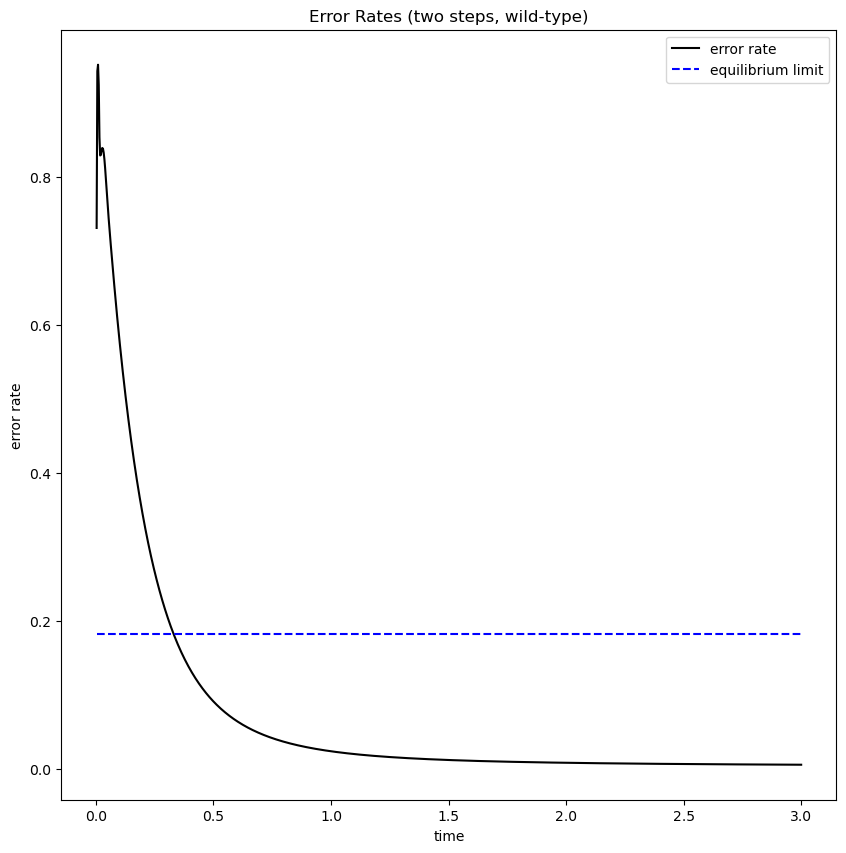

In [254]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (two steps, wild-type)')
st = 1
axs.plot(t[st:],ode_sol.y[9][st:]/ode_sol.y[8][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))

print('final error rate:'+str(np.round(ode_sol.y[9][-1]/ode_sol.y[8][-1],4)))

plt.savefig('2step_WT.jpg')  


In [239]:
# Parameters changed for MUTATED


hc_off = 1 #from 1 -> 5

hd_off = 2 #same



In [240]:
#implement

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics_2(t,y,kc_on,kc_off,kd_on,kd_off,mc,mc_r,md,md_r,lc_on,lc_off,ld_on,ld_off,nc,nc_r,nd,nd_r,hc_on,hc_off,hd_on,hd_off,w,w_r,c_total),tspan,y0,t_eval=t)



equilibrium error rate:0.1818
Kinetic Proofreading error rate:0.0331
final error rate:0.0245


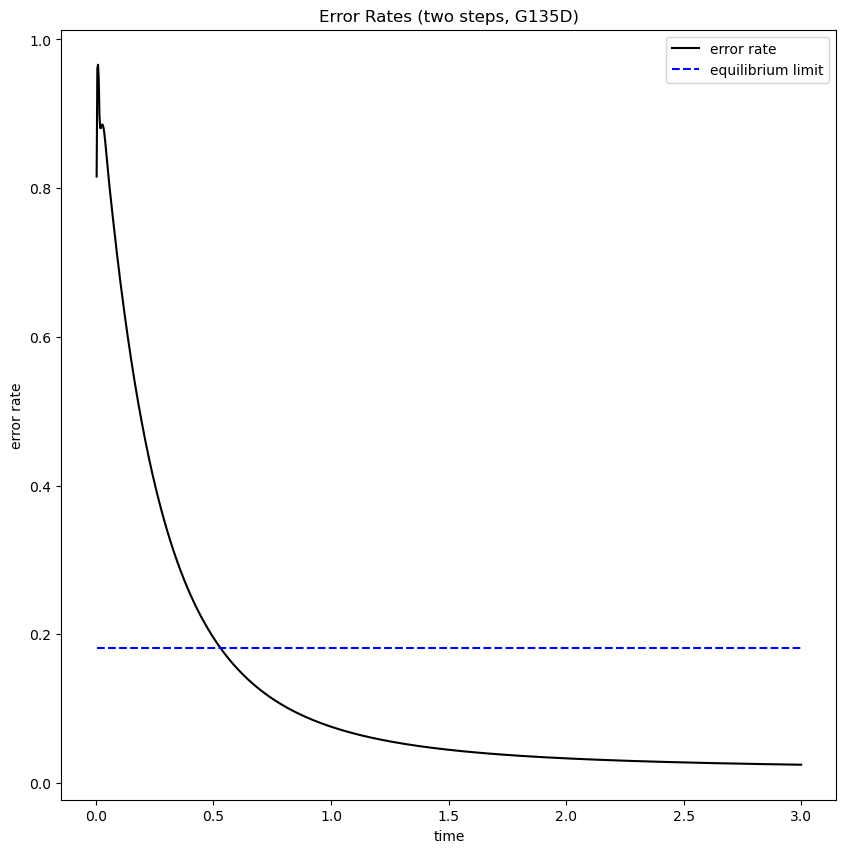

In [241]:
# Plot
fig,axs = plt.subplots(figsize=(10, 10))


axs.set_title('Error Rates (two steps, G135D)')
st = 1
axs.plot(t[st:],ode_sol.y[9][st:]/ode_sol.y[8][st:],'k-')
axs.set_xlabel('time')
axs.set_ylabel('error rate')
equilibrium_limit = (kc_off + W)/(kd_off + W)

axs.plot([t[st],t[-1]],[equilibrium_limit,equilibrium_limit],'b--')
axs.legend(['error rate','equilibrium limit']);

print('equilibrium error rate:'+str(np.round(equilibrium_limit,4)))
print('Kinetic Proofreading error rate:'+str(np.round(KP_limit,4)))
print('final error rate:'+str(np.round(ode_sol.y[9][-1]/ode_sol.y[8][-1],4)))

plt.savefig('2step_MUT.jpg')  
